In [ ]:
# EXERCICE CHAPITRE 4 

In [ ]:
#CRUD OPERATIONS 

In [ ]:
# You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (n:Superhero)
WHERE (n.Speed) IS NOT NULL
RETURN n.name, n.Speed
ORDER BY n.Speed DESC
LIMIT 10"""

results = graph.run(query)

for record in results:
    print(record)



In [ ]:
# Are they related to each other ?
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (n:Superhero)-[r]-(m:Superhero)
WHERE n.name IN ['Black Bolt', 'Stardust', 'Quicksilver', 'Nova', 'Thor', 'Silver Surfer', 'Galactus', 'Dormammu', 'Ego', 'Northstar']
AND m.name IN ['Black Bolt', 'Stardust', 'Quicksilver', 'Nova', 'Thor', 'Silver Surfer', 'Galactus', 'Dormammu', 'Ego', 'Northstar']
RETURN n.name, m.name"""

results = graph.run(query)

for record in results:
    print(record)

In [ ]:
#2 How many have collaborated atleast more than 10 times with another superhero?
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (a:Superhero)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab >= 10
WITH a
MATCH (a)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab >= 10
RETURN COUNT(DISTINCT a)"""

result = graph.run(query).evaluate()
print(f"{result} super héros ont collaboré plus de 10 fois avec un autre super héro")



In [ ]:
#3: Did the weakest of the MCU collaborated with the strongest ?
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query_weakest = """MATCH (n:Superhero)
WHERE (n.Total) IS NOT NULL
RETURN n.name
ORDER BY n.Total
LIMIT 1"""
result_weakest = graph.run(query_weakest).evaluate()

query_strongest = """MATCH (n:Superhero)
WHERE (n.Total) IS NOT NULL
RETURN n.name
ORDER BY n.Total DESC
LIMIT 1"""
result_strongest = graph.run(query_strongest).evaluate()

query_relation = f"""MATCH (a:Superhero {{name: "{result_weakest}"}})-[r:RELATION]-(b:Superhero {{name: "{result_strongest}"}})
RETURN COUNT(r)"""
result_relation = graph.run(query_relation).evaluate()

if result_relation > 0:
    print(f"{result_weakest} a collaboré avec {result_strongest}")
else:
    print(f"{result_weakest} n'a pas collaboré avec {result_strongest}")


In [ ]:
#4 : Give a stats that interests you !
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (n:Superhero)
WHERE (n.Strength) IS NOT NULL
RETURN n.name, n.Strength
ORDER BY n.Strength DESC
LIMIT 10"""

results = graph.run(query)

for record in results:
    print(record)



In [ ]:
#5: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).
# puisque je ne connais pas tous les noms des membres de la promo, on se contentera de leurs pseudo sur le groupe Whatsapp
names = ["Romain", "Céléstin", "abaolbatikh", "Werner", "Valentin", "Carl", "Paul", "Nathan", "Boune", "Adrien",
    "Ines", "Oumy", "Erik", "Julien", "Georgiana", "Huiyue", "SH", "Lath", "InesZ"]

from neo4j import GraphDatabase
import random
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

def create_m1_node(name):
    age = random.randint(20, 30)
    return Node("M1", name=name, age=age)

# Create M1 nodes with specific names
m1_nodes = [create_m1_node(name) for name in names]

# Randomly shuffle the nodes
random.shuffle(m1_nodes)

# Create collaboration relationships for each person with three others
for node in m1_nodes:
    # Ensure there are at least 3 other nodes available to collaborate with
    available_collaborators = [n for n in m1_nodes if n != node]
    random.shuffle(available_collaborators)
    collaborators = available_collaborators[:3]
    for collaborator in collaborators:
        # Ensure that the collaboration relationship is unidirectional
        if not graph.exists(Relationship(collaborator, "COLLABORATE_WITH", node)):
            rel = Relationship(node, "COLLABORATE_WITH", collaborator)
            graph.create(rel)

# Add M1 nodes to the graph
for node in m1_nodes:
    graph.create(node)
       



In [ ]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

# Romain's name
romain_name = "romain"

# Cypher query to get the age of people Romain collaborates with
query = """
MATCH (g:M1 {name: $romain_name})-[:COLLABORATE_WITH]->(collaborator)
RETURN collaborator.name AS collaborator_name, collaborator.age AS collaborator_age
"""

# Execute the query
result = graph.run(query, romain_name=romain_name)

# Retrieve and print the ages of people Romain collaborates with
for record in result:
    collaborator_name = record["collaborator_name"]
    collaborator_age = record["collaborator_age"]
    print(f"{collaborator_name}: {collaborator_age} years old")


In [ ]:
#7: Get nodes with age > 25.
query = """
MATCH (n:M1)
WHERE n.age > 25
RETURN n.name AS name, n.age AS age
"""

# Execute the query
result = graph.run(query)

# Retrieve and print the nodes with age > 25
for record in result:
    name = record["name"]
    age = record["age"]
    print(f"{name}: {age} years old")

In [9]:
# Real World Application 3
#You will work again on pubmed_last_100k.json. The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. 
#The following questions are meant to guide you through the process.

#1 :Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. 
    #If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. 
    #You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

import json
import re


graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")
with open('pubmed_cleaned.json', 'r') as json_file:
    data = json.load(json_file)


In [13]:
from py2neo import Node


graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")
for entry in data:
    title = entry['title']
    
    authors_affiliations = re.findall(r'name ml (.*?), affil str (.*?)\.', entry['authors'])
    
    for author, affiliation in authors_affiliations:
        author_node = Node("Author", name=author, title=title, affiliation=affiliation)
        graph.create(author_node)
    
    for i in range(len(authors_affiliations)):
        for j in range(i + 1, len(authors_affiliations)):
            author1 = authors_affiliations[i][0] 
            author2 = authors_affiliations[j][0] 
            graph.run(
                "MATCH (a:Author {name: $author1}), (b:Author {name: $author2}) "
                "CREATE (a)-[:SAME_TITLE]->(b)",
                author1=author1, author2=author2
            )

In [ ]:
#2 : How many authors have more than 2 affiliations ?

from neo4j import GraphDatabase

# Neo4j connection details
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")

query = """
        MATCH (a:Author)
        WHERE size(a.affiliations) > 2
        RETURN count(a) AS authorsWithMoreThanTwoAffiliations
        """

# Print the result
results = graph.run(query).to_data_frame()
print("Number of authors with more than two affiliations:", results)


In [ ]:
#3 : Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

import matplotlib.pyplot as plt
import numpy as np
from neo4j import GraphDatabase
import pandas as pd

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")

query1 =  """
MATCH (n)
WITH n, size((n)--()) AS degree
WITH degree, count(*) AS count
RETURN degree, count
ORDER BY degree
"""

results1 = graph.run(query).to_data_frame()

data = pd.DataFrame([dict(record) for record in result])

plt.bar(data["degree"], data["count"])
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Node Degree Distribution')
plt.show()



In [ ]:
#4 : Which country has seen the most international collaboration ?

from neo4j import GraphDatabase

# Neo4j connection details
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")

# Function to execute Cypher query
query2 = """
        // Match authors with affiliations in different countries
        MATCH (a:Author)-[:AFFILIATED_WITH]->(aff1:Affiliation),
        (b:Author)-[:AFFILIATED_WITH]->(aff2:Affiliation)
        WHERE a <> b AND aff1.country <> aff2.country
        // Count the collaborations between authors from different countries
        WITH aff1.country AS country1, aff2.country AS country2, count(*) AS collaborations
        // Aggregate and determine the country with the most collaborations
        RETURN country1, country2, collaborations
        ORDER BY collaborations DESC
        LIMIT 1
        """
        
record = result.single()
country1 = record["country1"]
country2 = record["country2"]
collaborations = record["collaborations"]

# Print the result
print("The countries {country1} and {country2} have the most international collaboration with {collaborations} collaborations.")


In [ ]:
# 5 : Who are the top 10 collaborators and what is their affiliation ?

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")


query = """
MATCH (a:Author)-[:SAME_TITLE]-(:Author)
WITH DISTINCT a, COUNT(DISTINCT id(a)) AS collaborations, COLLECT(DISTINCT a.affiliation) AS affiliations
ORDER BY collaborations DESC
LIMIT 10
RETURN a.name AS Author, affiliations[0] AS Affiliation, collaborations
"""

results2 = graph.run(query).to_data_frame

print(results2)

In [ ]:
# 6 
# Compter le nombre de papier en économie écris en france

from neo4j import GraphDatabase

# Neo4j connection details
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")

query = """MATCH (a:Author)-[:WRITTEN]->(m:Paper)
WHERE toLower(m.domain) CONTAINS 'economy' AND a.country = 'France'
RETURN COUNT(DISTINCT m) AS num_papers
        """
results3 = graph.run(query).to_data_frame

print(results3)


In [15]:
# Real World Application 4
#1) How many actors played in more than 2 movie ? Get their names and year they were born.

import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="movie")  


In [25]:
query = """ MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, count(m) as num_movies
WHERE num_movies > 2
RETURN a.name, a.born """

results = graph.run(query).to_data_frame()
print(len(results), "actors played in more than 2 movies")
names = results['a.name']
born = results['a.born']
for i in range(len(results)):
    print(names[i], born[i])

15 actors played in more than 2 movies
Hugo Weaving 1960
Laurence Fishburne 1961
Carrie-Anne Moss 1967
Keanu Reeves 1964
Cuba Gooding Jr. 1968
Kevin Bacon 1958
Jack Nicholson 1937
Tom Cruise 1962
Meg Ryan 1961
Helen Hunt 1963
Robin Williams 1951
Tom Hanks 1956
Gene Hackman 1930
Ben Miles 1967
Bill Paxton 1955


In [26]:
#2) In how many movies did Tom hanks play ?
query = """ MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie)
RETURN count(m) """

results = graph.run(query).to_data_frame()
print("Tom Hanks played in", results['count(m)'][0], "movies")

Tom Hanks played in 12 movies


In [27]:
#3) In average in how many movies do actors play in ?
query = """ MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, count(m) as num_movies
RETURN avg(num_movies) """

results = graph.run(query).to_data_frame()
print("In average actors play in", results['avg(num_movies)'][0], "movies")

In average actors play in 1.6862745098039222 movies


In [28]:
#4) In average how many actors are there in a movie ?

query = """ MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH m, count(a) as num_actors
RETURN avg(num_actors) """

results = graph.run(query).to_data_frame()
print("In average there are", results['avg(num_actors)'][0], "actors in a movie")

In average there are 4.526315789473684 actors in a movie


In [29]:
#5 ) In average how many writers is needed to write a movie ?
query = """ MATCH (w:Person)-[:WROTE]->(m:Movie)
WITH m, count(w) as num_writers
RETURN avg(num_writers) """

results = graph.run(query).to_data_frame()
print("In average there are", results['avg(num_writers)'][0], "writers in a movie")

In average there are 1.25 writers in a movie


In [34]:
#6) What is the proportion of writers that also directed the movie ?
query = """
MATCH (w:Person)-[:WROTE]->(m:Movie)<-[:DIRECTED]-(d:Person)
WHERE w.name = d.name
WITH m, count(w) as num_writers, count(d) as num_directors
RETURN CASE WHEN num_writers > 0 THEN toFloat(num_directors) / num_writers ELSE 0 END AS proportion
"""

results = graph.run(query).to_data_frame()
print("Proportion of writers that also directed the movie is", results['proportion'][0])


Proportion of writers that also directed the movie is 1.0


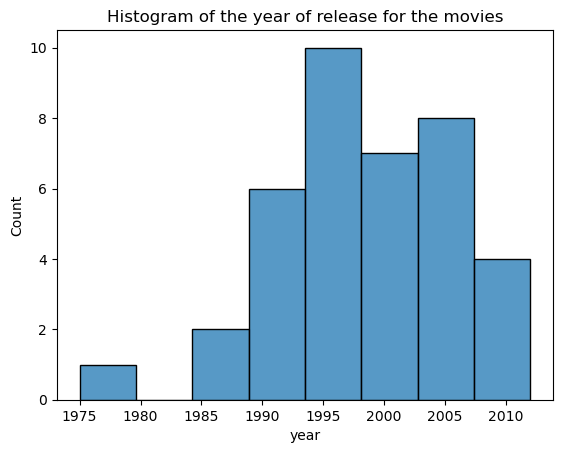

In [35]:
#7) Do an histogram of the year of release for the movies.
import seaborn as sns

query = """ MATCH (m:Movie) RETURN m.released as year """
data = graph.run(query).to_data_frame()
ax = sns.histplot(data["year"])
ax.title.set_text("Histogram of the year of release for the movies")

In [36]:
# 8) Who are the 10 actors with the most movie played in
query = """ MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, count(m) as num_movies
RETURN a.name, num_movies
ORDER BY num_movies DESC
LIMIT 10 """

results = graph.run(query).to_data_frame()
print(results)

               a.name  num_movies
0           Tom Hanks          12
1        Keanu Reeves           7
2            Meg Ryan           5
3      Jack Nicholson           5
4        Hugo Weaving           5
5    Cuba Gooding Jr.           4
6         Kevin Bacon           3
7  Laurence Fishburne           3
8    Carrie-Anne Moss           3
9          Tom Cruise           3


In [37]:
#9) Delete every movie made by a director of your choosing

query = """ MATCH (d:Person {name: 'Howard Deutch'})-[:DIRECTED]->(m:Movie)
DETACH DELETE m """

graph.run(query)

(No data)

In [42]:
#10)  Give some statistics that you find interesting.
query = """MATCH (w:Person)-[:WROTE]->(m:Movie)
WITH w, count(m) AS num_wrote_movies
MATCH (w)-[:ACTED_IN]->(m)
WITH w, num_wrote_movies, count(distinct m) AS num_movies_with_actor_role
RETURN CASE 
    WHEN num_wrote_movies > 0 THEN toFloat(num_movies_with_actor_role) / num_wrote_movies 
    ELSE 0 
END AS proportion
        """

results1 = graph.run(query).to_data_frame()
print("Proportion of writers that also acted in the movie is", results1['proportion'][0])

Proportion of writers that also acted in the movie is 1.0


In [45]:
#11) Who played the most movies with KR
query = """
        MATCH (k:Person {name: 'Keanu Reeves'})-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(a:Person)
        WHERE a <> k
        WITH a, count(distinct m) AS num_movies_with_keanu
        RETURN a.name AS actor, num_movies_with_keanu
        ORDER BY num_movies_with_keanu DESC
        LIMIT 1
        """

results2 = graph.run(query).to_data_frame()
print(results2)
# The actor who played the most movie with KR is hugo weaving with  movies

          actor  num_movies_with_keanu
0  Hugo Weaving                      3


In [46]:
# Real World Application 5

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")
graph.delete_all()

In [50]:
import pandas as pd
import tqdm

target = pd.read_csv("FR_target.csv")
target = target.drop_duplicates(subset="id")
target.shape

(6549, 6)

In [51]:

try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id IS UNIQUE")
except:
    print("Constraint already exists")

transaction_list = []
for row in tqdm.tqdm(target.iterrows()):
    id = row[1]["id"]
    days = row[1]["days"]
    mature = row[1]["mature"]
    views= row[1]["views"]
    partner = row[1]["partner"]
    new_id = row[1]["new_id"]
    transaction_list.append({"id": id, "days": days, "mature": mature, "views": views, "partner": partner, "new_id": new_id})
    if len(transaction_list) == 1000:
        transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

Constraint already exists


6549it [00:01, 4791.34it/s]


In [53]:
edges = pd.read_csv("FR_edges.csv")
edges = edges.drop_duplicates()
edges.shape

(112666, 2)

In [55]:
import itertools
import tqdm
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")

transaction_list = []
transaction = """UNWIND $json as data
    MATCH (a:Streamer),(b:Streamer)
    WHERE a.new_id = data.from AND b.new_id = data.to
    MERGE (a)-[r:RELATION]->(b)
    ON CREATE
    SET r.n_collab = 1
    ON MATCH
    SET r.n_collab = r.n_collab + 1
    """
it = 0
for edge in tqdm.tqdm(edges.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

 10%|█         | 605/5882 [51:00<7:24:54,  5.06s/it] 


ConnectionBroken: Failed to read message

In [ ]:
# 1.Give the IDs of the top 10 streamers that have atleast one collaboration.

query = """ MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WITH n, count(r) as collab
WHERE collab >= 1
RETURN n.id as streamer_id, collab
ORDER BY collab DESC
LIMIT 10
  """

result = graph.run(query).to_data_frame()
print(result)

In [ ]:
#2 : Create a density of node degrees. Do you observe a power scale law ? What does it mean ?
import seaborn as sns

# Cypher Query
query = """
MATCH (s)
WITH s, size(()-[:RELATION]->(s)) as degree
RETURN degree
"""

# Stream the data directly from Neo4j without loading it all into memory at once
result = graph.run(query)

# Extract degrees from the result
degrees = [record["degree"] for record in result]

# Plot the distribution of degrees using sns.histplot()
ax = sns.histplot(degrees, kde=True)
ax.set_title("Density of degrees")


In [ ]:
#3 How many streamers has the tag "mature" ?

# Neo4j connection details
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")

# Neo4j Cypher query
query = """ 
MATCH (n:Streamer)
WHERE n.mature = True
RETURN count(n) as mature_streamers 
"""

# Execute the query
result = graph.run(query).to_data_frame()

# Print the result
print(f"{result['mature_streamers'][0]} streamers have the tag 'mature'.")


In [ ]:
# 4. Is the collaboration correlated to the "mature" tag ?

query = """MATCH (s:Streamer)-[r:RELATION]->()
WITH s.mature AS mature, count(r) AS collab_count
RETURN mature, collab_count
 """

result = graph.run(query).to_data_frame()
corr = result['mature'].corr(result['collab_count'])
print(result)
print(corr) 

In [ ]:
#5 Do partners collaborate more than non partners ?


query1 = """
MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WHERE n <> m AND n.partner = True AND m.partner = True
RETURN count(r) as collab_p
"""

# Execute the first query
result1 = graph.run(query1).to_data_frame()

# Query for non-partners collaboration
query2 = """
MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WHERE n <> m AND n.partner = False AND m.partner = False
RETURN count(r) as collab_np
"""

# Execute the second query
result2 = graph.run(query2).to_data_frame()

# Compare the results and print the conclusion
if result1["collab_p"][0] > result2["collab_np"][0]:
    print("Partners collaborate more than non-partners.")
else:
    print("Non-partners collaborate more than partners.")

In [ ]:
#Real World Application 6 

import pandas as pd
from py2neo import Graph, Node, Relationship 

# File path to the CSV
csv_file = "stack_network_nodes.csv"

# Read the CSV data into a DataFrame
data = pd.read_csv(csv_file)

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Create nodes in Neo4j from the CSV data
for index, row in data.iterrows():
    name = row['name']
    group = row['group']
    nodesize = row['nodesize']
    
    # Create a node with the corresponding attributes
    node = Node("Node", name=name, group=group, nodesize=nodesize)
    
    # Add the node to the database
    graph.create(node)



In [ ]:
from py2neo import NodeMatcher

# File path to the CSV
csv_links_file = "stack_network_links.csv"

# Read the CSV data into a DataFrame
links_data = pd.read_csv(csv_links_file)

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# NodeMatcher for finding nodes by name
node_matcher = NodeMatcher(graph)

# Dictionary to store node names and their corresponding IDs
node_ids = {node["name"]: node.identity for node in node_matcher.match("Node")}

# Create relationships in Neo4j from the CSV link data
for index, row in links_data.iterrows():
    source_name = row['source']
    target_name = row['target']
    value = row['value']
    
    # Get the IDs of the source and target nodes
    source_id = node_ids.get(source_name)
    target_id = node_ids.get(target_name)
    
    # Check if source and target nodes exist in the database
    if source_id is not None and target_id is not None:
        # Create a relationship between the source and target nodes with the corresponding weight
        relation = Relationship(graph.nodes[source_id], "LINKS_TO", graph.nodes[target_id], weight=value)
        
        # Add the relationship to the database
        graph.create(relation)


In [ ]:
#1 What are the 10 most popular keywords ?
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

query = """
MATCH (t)
RETURN t.name AS tag, sum(t.nodesize) AS popularity
ORDER BY popularity DESC
LIMIT 10
"""

# Execute the query and retrieve the results
result = graph.run(query)

# Print the results
for record in result:
    print(f"{record['tag']} : {record['popularity']}")

In [ ]:
#2 : What are the top 10 Co-occurence ?
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

query2 = """MATCH (n1)-[:RELATION]->(n2)
WITH n1, n2, COUNT(*) AS co_occurrences
ORDER BY co_occurrences DESC
LIMIT 10
RETURN n1.name AS node1, n2.name AS node2, co_occurrences
        """

results = graph.run(query).to_data_frame()
print("The top 10 co_occurences are:", results)


In [ ]:
#3 : How many keywords are in group 1 ?
from py2neo import Graph

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Cypher query to find the top 10 co-occurrences
query = """
MATCH (k1:Node)-[:LINKS_TO]-(k2:Node)
WHERE k1.name < k2.name
RETURN k1.name AS Keyword1, k2.name AS Keyword2, COUNT(*) AS co_occurrences
ORDER BY co_occurrences DESC
LIMIT 10
"""

# Execute the query and retrieve the results
result = graph.run(query)

# Print the results
for record in result:
    print(f"{record['Keyword1']} and {record['Keyword2']}: {record['co_occurrences']} co-occurrences")


In [ ]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Cypher query to count keywords in group 1
query = """
MATCH (n:Node)
WHERE n.group = 1
RETURN COUNT(n) AS keyword_count
"""

# Execute the query and retrieve the result
result = graph.run(query)

# Get the number of keywords in group 1 from the result
keyword_count = result.evaluate()

print("Number of keywords in group 1:", keyword_count)


In [ ]:
#4 : Is the Co-occurence correlated to the "group" of the keyword ?

graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Cypher query to count co-occurrences within and outside the same group
query = """
MATCH (t1:Node)-[r:LINKS_TO]->(t2:Node)
WITH t1.group = t2.group AS same_group, COUNT(*) AS co_occurrences
RETURN 
    SUM(CASE WHEN same_group THEN co_occurrences ELSE 0 END) AS co_occurrences_group,
    SUM(CASE WHEN NOT same_group THEN co_occurrences ELSE 0 END) AS co_occurrences_NONgroup
"""

# Execute the query and retrieve the result
result = graph.run(query).evaluate()

# Print the results
print("Co-occurrence within the same group:", result['co_occurrences_group'])
print("Co-occurrence outside the same group:", result['co_occurrences_NONgroup'])


In [ ]:
#5 Show the occurences of "NoSQL" overtime 
from py2neo import Graph
import matplotlib.pyplot as plt

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Cypher query to count occurrences of "NoSQL" for each year
query = """
MATCH (d:Document)
WHERE d.text CONTAINS 'NoSQL'
RETURN date(d.date).year AS year, count(*) AS occurrences
ORDER BY year
"""

# Execute the query and retrieve the results
result = graph.run(query)

# Extract years and occurrences from the result
years = []
occurrences = []
for record in result:
    years.append(record['year'])
    occurrences.append(record['occurrences'])

# Plot the occurrences over time
plt.plot(years, occurrences, marker='o')
plt.xlabel('Year')
plt.ylabel('Occurrences of "NoSQL"')
plt.title('Occurrences of "NoSQL" over Time')
plt.grid(True)
plt.show()
